In [1]:
# Instalation des librairies avec pip ou conda
#!pip install pandas numpy matplotlib seaborn scipy
#!conda install pandas numpy matplotlib seaborn scipy -y

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis, skew, norm
plt.style.use('dark_background')

In [3]:
# Fonctions d'affichages / stats
def measure_intervals(df):
     # Calculate differences between consecutive timestamps
    intervals = df.index.to_series().diff().dropna()

    # Calculate stats
    min_interval = intervals.min()
    max_interval = intervals.max()
    mode_interval = intervals.mode().iloc[0]
    
    # Create result dictionary
    results = {
        'Min Interval': min_interval,
        'Max Interval': max_interval,
        'Mode Interval': mode_interval
    }
    
    # Plot histogram for intervals
    plt.figure(figsize=(8, 4))
    plt.hist(intervals.dt.total_seconds() / 60, bins=200, alpha=0.5, color='cyan')
    
    # Add vertical lines for mode
    plt.axvline((mode_interval.total_seconds() / 60), color='yellow', linestyle='dashed', linewidth=2)  # Mode line
    
    plt.title('Histogram of Intervals between Dollar Bars')
    plt.xlabel('Interval (minutes)')
    plt.ylabel('Frequency')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()
    
    return results

def plot_candlestick(dollar_bars):
    # Create figure with two subplots sharing x axis
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), height_ratios=[3, 1], sharex=True)
    
    # Set background color
    fig.patch.set_facecolor('#1f1f1f')  # Dark gray background for figure
    ax1.set_facecolor('#1f1f1f')        # Dark gray background for main plot
    ax2.set_facecolor('#1f1f1f')        # Dark gray background for volume plot
    
    # Colors for bullish and bearish bars
    color_up = 'green'
    color_down = 'red'
    edge_color = 'white'
    grid_color = '#333333'  # Darker gray for grid lines
    
    # Plot candlesticks on main axis
    for idx, row in dollar_bars.iterrows():
        color = color_up if row['close'] > row['open'] else color_down

        # Plot the wicks
        ax1.plot([idx, idx], [row['low'], row['high']], color=edge_color, linewidth=1)

        # Plot the body with edge
        ax1.plot([idx, idx], [row['open'], row['close']], color=color, linewidth=4)
        ax1.plot([idx, idx], [row['open'], row['close']], color=edge_color, linewidth=5, zorder=0)

    # Plot volume on second axis
    ax2.bar(dollar_bars.index, dollar_bars['dv'],alpha=0.7 ,width=0.01)

    # Set labels and title with white text
    ax1.set_title('Dollar Bars Candlestick Chart', color='white')
    ax1.set_ylabel('Price', color='white')
    ax2.set_xlabel('Time', color='white')
    ax2.set_ylabel('Dollar Volume', color='white')
    
    # Configure grid
    ax1.grid(True, color=grid_color, linestyle='--', linewidth=0.5)
    ax2.grid(True, color=grid_color, linestyle='--', linewidth=0.5)
    
    # Set tick colors to white
    ax1.tick_params(colors='white')
    ax2.tick_params(colors='white')
    
    plt.xticks(rotation=45)
    plt.tight_layout()


---
### Creation des dollars bars
---

- La creation des dollars bars se fait normalement a partir des tick data,  
cependant pour simplifier la méthode et la rendre accéssible a tous,  
je vais utiliser les données historiques de binance en m1 .

- Pour récupérer les données de binance, je vous invite a suivre la vidéo suivante : https://www.youtube.com/watch?v=0UP6BZc8sCs&t=1s

In [4]:
# Chargement Données SOL/USDT en m1
df = pd.read_csv('solusdt.csv', index_col='close_time', parse_dates=True)
df.drop(['num_trades', 'taker_buy_vol', 'taker_buy_dv'], axis=1, inplace=True)
df.head()

,open,high,low,close,volume,dv
close_time,,,,,,
2024-06-01 00:01:00,165.761,165.965,165.761,165.852,5976.0,991102.069
2024-06-01 00:02:00,165.852,165.961,165.776,165.815,4704.0,780352.609
2024-06-01 00:03:00,165.814,166.118,165.799,166.081,19076.0,3166830.046
2024-06-01 00:04:00,166.080,166.146,165.967,166.097,2851.0,473423.763
2024-06-01 00:05:00,166.089,166.184,166.061,166.183,2092.0,347564.965


In [5]:
def create_dollar_bars(data, threshold_column):
    # Initialisation de la liste pour stocker les $barres
    dollars_bars = []
    cum_dv = 0

    for idx, row in data.iterrows():
        # Si le cumul de dv est égal à 0, on initialise la barre
        if cum_dv == 0:
            current_bar = {
                'open': row['open'],
                'high': float('-inf'),
                'low': float('inf'),
                'volume': 0,
                'dv': 0,
                'close': None}
        
        # On ajoute le montant en $ de la ligne a la barre
        cum_dv += row['dv']
        
        # Mise à jour des données de la barre
        current_bar['high'] = max(current_bar['high'], row['high'])
        current_bar['low'] = min(current_bar['low'], row['low'])
        current_bar['volume'] += row['volume']
        current_bar['dv'] += row['dv']
        
        # Vérifier si le seuil est atteint
        if cum_dv >= row[threshold_column]:
            # Cloturer la $bars
            current_bar['close'] = row['close']
            current_bar['close_time'] = idx
            
            # Ajout de la $bars a la liste
            dollars_bars.append(current_bar.copy())
            
            # Réinitialisation
            cum_dv = 0
            
    # Retourne un DataFrame avec l'index sur close_time
    return pd.DataFrame(dollars_bars).set_index('close_time')

In [6]:
# Definition d'un seuil fixe en $
df['threshold'] = 100000000

# Creation des dollars bars
df_dollars_bars = create_dollar_bars(df, 'threshold')
df_dollars_bars.head()

,open,high,low,volume,dv,close
close_time,,,,,,
2024-06-01 02:36:00,165.761,167.438,165.761,600242.0,1.000723e+08,167.198
2024-06-01 05:51:00,167.193,167.924,166.784,597760.0,1.000082e+08,166.985
2024-06-01 09:04:00,166.984,167.487,166.532,602206.0,1.006148e+08,167.320
2024-06-01 12:51:00,167.312,167.604,166.672,601761.0,1.005533e+08,167.205
2024-06-01 15:26:00,167.205,167.892,166.857,598870.0,1.002576e+08,167.677


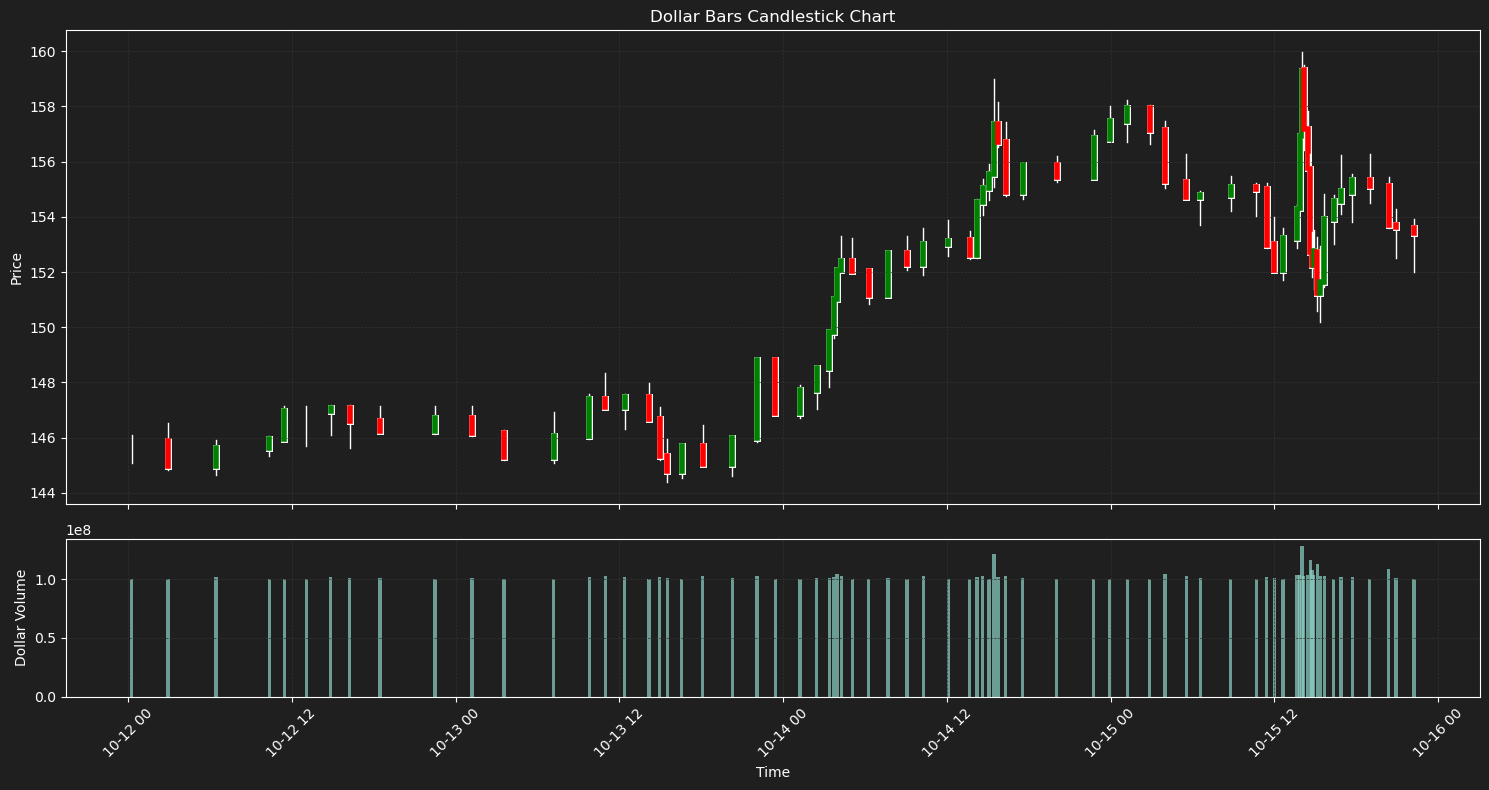

In [7]:
plot_candlestick(df_dollars_bars['2024-10-12':'2024-10-15'])

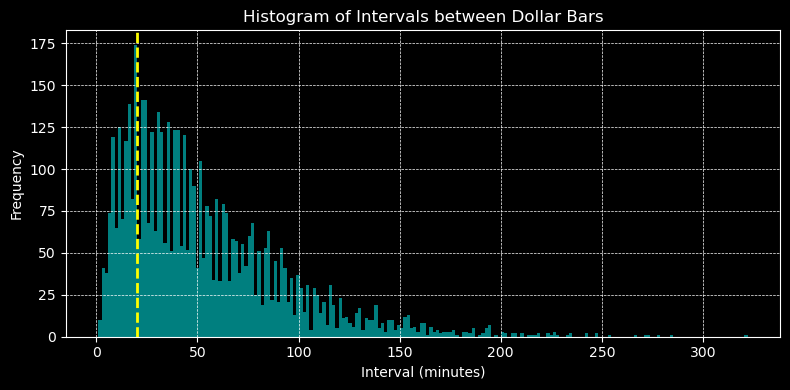

{'Min Interval': Timedelta('0 days 00:01:00'),
 'Max Interval': Timedelta('0 days 05:22:00'),
 'Mode Interval': Timedelta('0 days 00:20:00')}

In [8]:
# Measure de l'intervalle entre les $bars
measure_intervals(df_dollars_bars)

---
### Ajout d'un seuil dynamique
---

- S'adapte aux conditions de marché 
- S'adapte a chaque actif

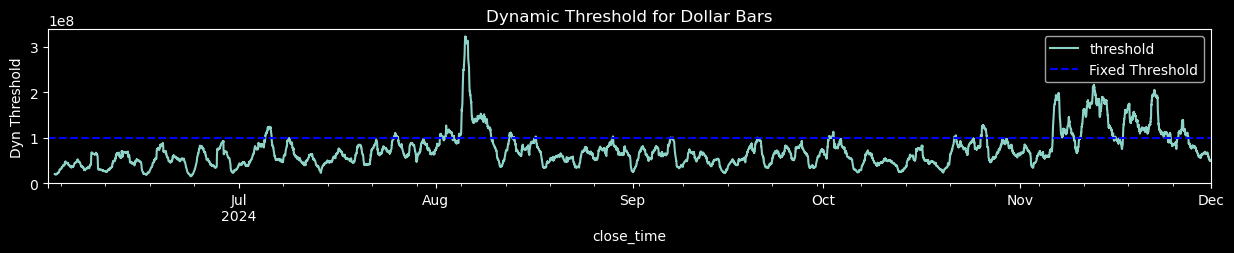

In [9]:
# Creation d'un seuil dynamique pour l'echantillonnage des $ bars 
df['threshold'] = df['dv'].rolling(window=1500).sum() * 0.025

# Affichage
df.threshold.plot(figsize=(15, 2), title='Dynamic Threshold for Dollar Bars', ylabel='Dyn Threshold')
plt.axhline(y=100000000, color='blue', linestyle='--', label='Fixed Threshold')
plt.legend()
plt.show()

In [10]:
# Creation des $ bars avec le seuil dynamique
Dyn_dollar_bars = create_dollar_bars(df, 'threshold')

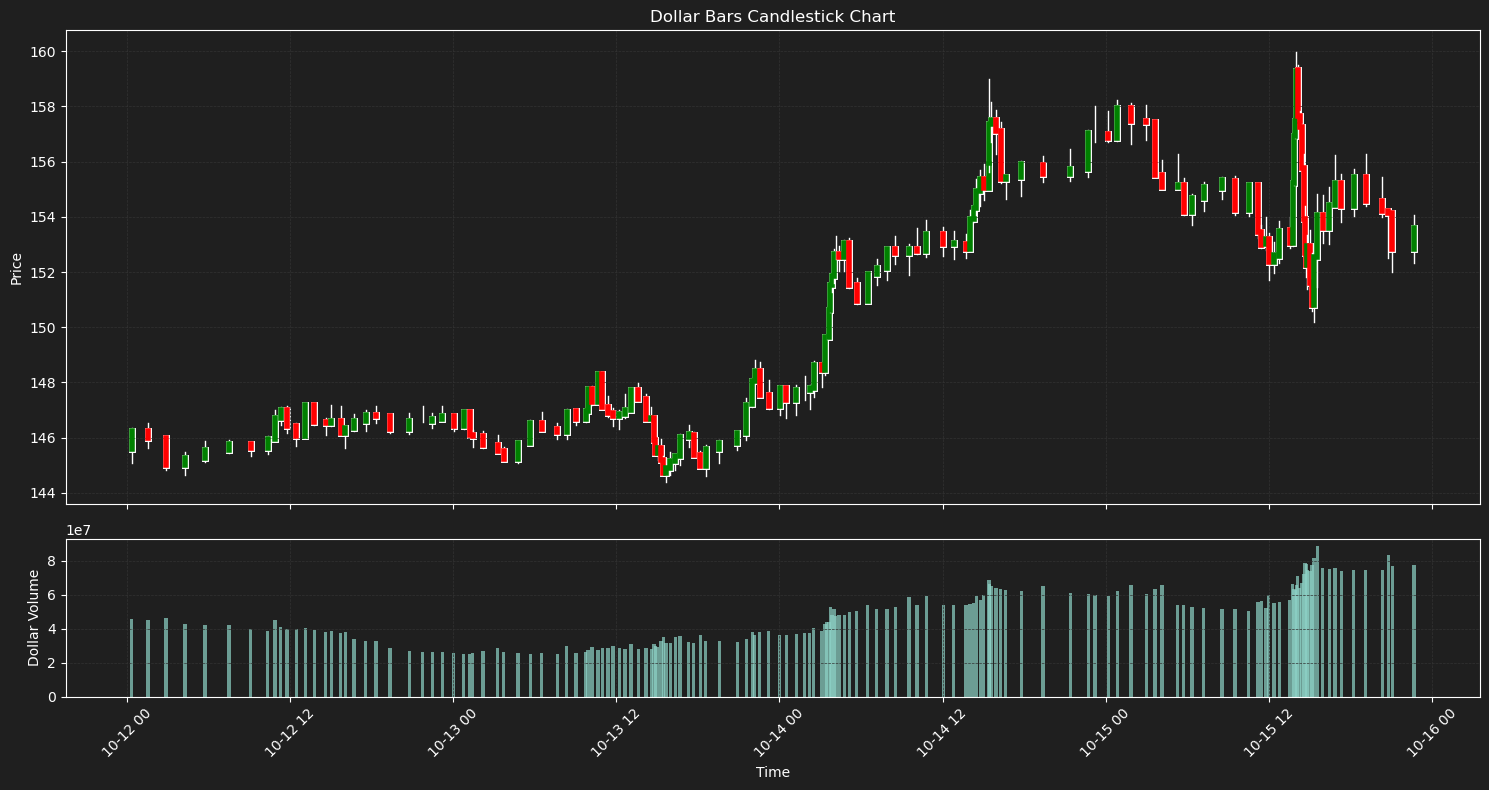

In [11]:
plot_candlestick(Dyn_dollar_bars['2024-10-12':'2024-10-15'])

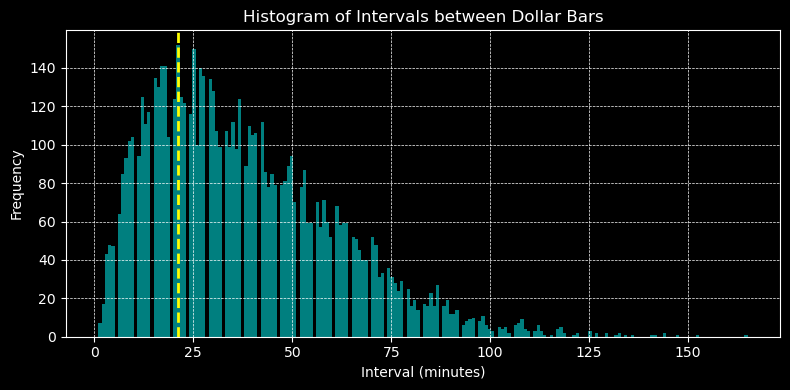

{'Min Interval': Timedelta('0 days 00:01:00'),
 'Max Interval': Timedelta('0 days 02:45:00'),
 'Mode Interval': Timedelta('0 days 00:21:00')}

In [12]:
# Measure de l'interval entre les $bars
measure_intervals(Dyn_dollar_bars)

In [13]:
# Calcul du taux de compression entre les time bars et les dollar bars dynamiques
print(f"Nombre de bars initial (time bars): {len(df)}")
print(f"Nombre de bars après compression (dollar bars): {len(Dyn_dollar_bars)}")
print(f"Taux de compression: {(1 - len(Dyn_dollar_bars)/len(df)) * 100:.1f}%")

Nombre de bars initial (time bars): 263521
Nombre de bars après compression (dollar bars): 6925
Taux de compression: 97.4%


#### Conlusion n°1 :
- On remarque que l'échantillonnage des $bars s'adapte bien a l'activité du marché
- Compression des données en gardant la réactivité du m1

---
### Évaluation des $bars vs time bars
---

#### Méthode d'évaluation :
- Comparaison des log-returns entre $bars et time bars
- Analyse de la normalité des distributions

#### Pourquoi cette méthode ?
1. Les log-returns permettent une meilleure comparaison des variations de prix
   en normalisant les changements relatifs
2. Une distribution proche de la normale est recherchée car elle :
   - Moins de valeurs extremes et moins de zéros (en gros moins de bruit...)
   - Améliore les performances des modèles statistiques/mathématiques/IA
   - Permet une meilleure gestion des risques (moins d'extremes)

#### Hypothèse
- Les $bars devraient produire une distribution plus proche de la normale que les time bars classiques

---

#### Comment calculer les Rendements Logarithmiques (log_returns) ?

$\text{Log-Return} = \ln(\frac{\text{Prix actuel}}{\text{Prix précédent}})$

  
Exemple sur le prix en m1 :
- Prix à 10:01:00 = 100€
- Prix à 10:02:00 = 105€

**Calcul classique du rendement :**
- Rendement simple = (105 - 100) / 100 = 5%

**Calcul du log-return :**
- Log-return = ln(105/100) ≈ 0.0488 soit environ 4.88%

#### Calcul des log_returns

In [14]:
# Calcul des log_returns des $bars
log_returns_dollars_bars = np.log(Dyn_dollar_bars['close'] / Dyn_dollar_bars['close'].shift(1)).dropna()
log_returns_1min_bars = np.log(df['close'] / df['close'].shift(1)).dropna()

# Calcul des log_returns des time bars pour un equivalent 21min (appl2appl)
time_bars_df = df.resample('21min').agg({
        'open': 'first',  # First price in the interval
        'high': 'max',    # Highest price in the interval
        'low': 'min',     # Lowest price in the interval
        'close': 'last',  # Last price in the interval
        'volume': 'sum',  # Total volume in the interval
        'dv': 'sum'       # Total dollar volume in the interval (optional field)
    }).dropna()  # Drop intervals with no data

# Calcul des log_returns pour les timebars de 21min
log_returns_time_bars = np.log(time_bars_df['close'] / time_bars_df['close'].shift(1)).dropna()

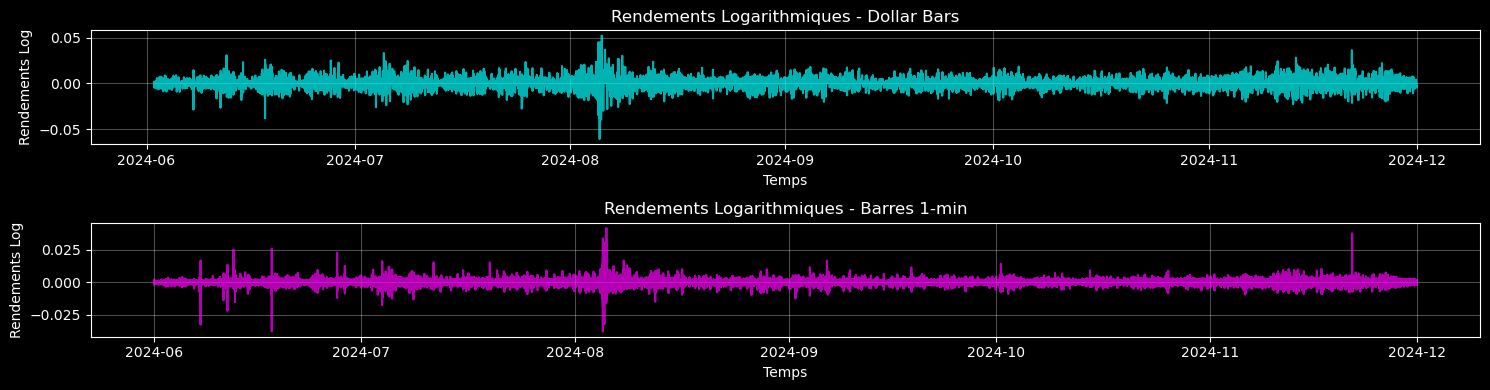

In [15]:
# Affichage des log_returns
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 4), height_ratios=[1, 1])

# Tracer les rendements logarithmiques pour les Dollar Bars
ax1.plot(log_returns_dollars_bars, color='cyan', alpha=0.7)
ax1.set_title('Rendements Logarithmiques - Dollar Bars')
ax1.set_xlabel('Temps')
ax1.set_ylabel('Rendements Log')
ax1.grid(True, alpha=0.3)

# Tracer les rendements logarithmiques pour les barres de 1 minute
ax2.plot(log_returns_1min_bars, color='magenta', alpha=0.7)
ax2.set_title('Rendements Logarithmiques - Barres 1-min')
ax2.set_xlabel('Temps')
ax2.set_ylabel('Rendements Log')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
#### Comparaison des distributions

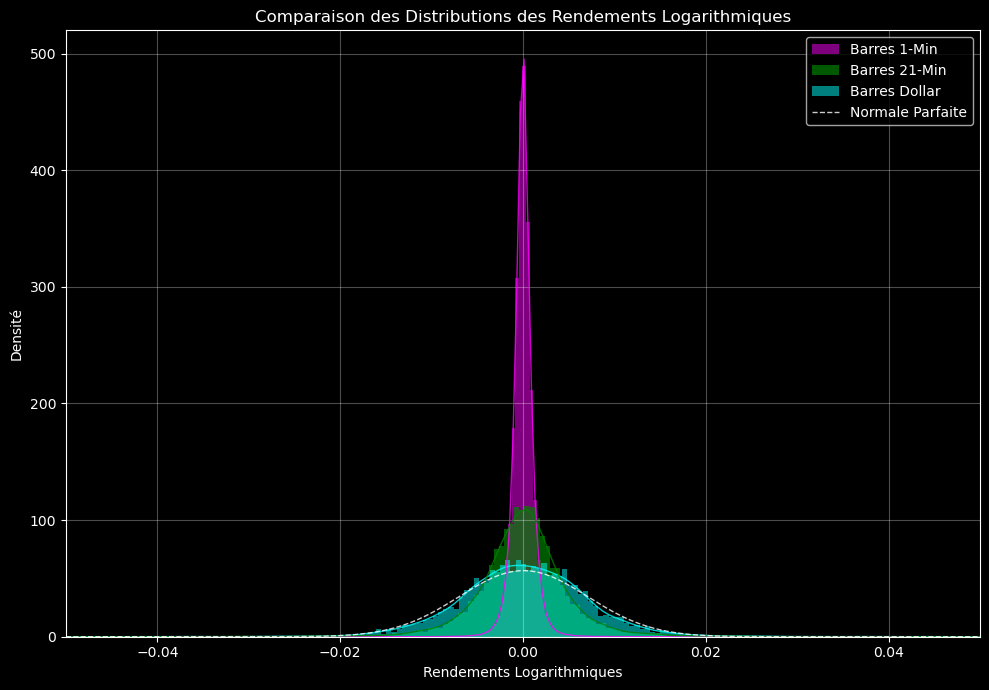

In [16]:
# Configuration de la taille du graphique
plt.figure(figsize=(10, 7))

# Ajustement d'une distribution normale aux données
mu, sigma = norm.fit(log_returns_dollars_bars)
x = np.linspace(-0.05, 0.05, 2000)
perfect_normal = norm.pdf(x, mu, sigma)

# Traçage des histogrammes pour chaque type de barre
plt.hist(log_returns_1min_bars, bins=200, alpha=0.5, color='magenta', label='Barres 1-Min', density=True)
plt.hist(log_returns_time_bars, bins=200, alpha=0.7, color='green', label='Barres 21-Min', density=True)
plt.hist(log_returns_dollars_bars, bins=200, alpha=0.5, color='cyan', label='Barres Dollar', density=True)

# Ajout des estimations de densité par noyau (KDE)
sns.kdeplot(data=log_returns_dollars_bars, color='cyan', linewidth=1, alpha=0.8)
sns.kdeplot(data=log_returns_1min_bars, color='magenta', linewidth=1, alpha=0.8)
sns.kdeplot(data=log_returns_time_bars, color='green', linewidth=1, alpha=0.8)

# Ajout de la courbe de distribution normale théorique
plt.plot(x, perfect_normal, '--', color='white', alpha=0.8, label='Normale Parfaite', linewidth=1)

# Paramètres de mise en forme du graphique
plt.title('Comparaison des Distributions des Rendements Logarithmiques')
plt.xlabel('Rendements Logarithmiques')
plt.ylabel('Densité')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(-0.05, 0.05)

# Optimisation de la mise en page et affichage
plt.tight_layout()
plt.show()

#### Statistiques de distribution normale "Parfaite"
- **Kurtosis** (l'aplatissement) = 0
- **Skewness** (l'asymétrie) = 0 

In [17]:
for name, returns in [('# 1-Min Bars', log_returns_1min_bars),
                     ('# 21-Min Bars', log_returns_time_bars),
                     ('# Dollar Bars', log_returns_dollars_bars)]:
    print(f"\n{name}:")
    print(f"Kurtosis: {kurtosis(returns):.4f}")
    print(f"Skewness: {skew(returns):.4f}")


# 1-Min Bars:
Kurtosis: 50.5883
Skewness: 0.1795

# 21-Min Bars:
Kurtosis: 8.6958
Skewness: 0.1677

# Dollar Bars:
Kurtosis: 3.4428
Skewness: 0.0403


---
### Conclusion
- Les $bars produisent une distribution plus proche de la normale que les time bars classiques
- Elles capturent mieux les variations de prix en s'adaptant aux conditions de marché

---
### Références

> The Volume Clock: Insights into the High Frequency  (Dr Lopez de Prado)  
https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2034858
